In [306]:
#Library imports
import re
import os
import sys
import shutil
import time
import math
import fnmatch
import random
import warnings
import numpy as np
import pandas as pd
import scipy.stats as scs
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict

import scipy.stats as scs

import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

# Allows access to scripts and modules relative to the parent directory.
parent = os.getcwd()
sys.path.append(os.path.join(parent, "functions"))

# Project specific user driven functions
from cleaning_functions import *

# My open source reusable user driven function repository.
from random_lumberjacks.src.random_lumberjacks.cleaning.cleaning_functions import *
from random_lumberjacks.src.random_lumberjacks.model.model_classes import *
from random_lumberjacks.src.random_lumberjacks.visualization.visualization_functions import *

#Notebook arguments
%matplotlib inline

In [2]:
water_final = pd.read_csv("data/Water_FINAL.csv", low_memory = False)
water_dict = pd.read_csv("data/CBP_water_dictionary_final.csv")

In [3]:
water_final.head()

,Unnamed: 0,Unnamed: 0.1,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,0,2143,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.93002800000002 39.480194),20600020206,Bohemia River,24015,Cecil County,MD
1,1,2145,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.902528 39.480444),20600020206,Bohemia River,24015,Cecil County,MD
2,2,2147,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,S,1-10 knots,MD,POINT (-75.873639 39.466889),20600020206,Bohemia River,24015,Cecil County,MD
3,3,2151,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.854444 39.454),20600020206,Bohemia River,24015,Cecil County,MD
4,4,2152,NaN,NaN,NaN,NaN,NaN,CMC,04/28/2018,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.84352800000001 39.463667),20600020206,Bohemia River,24015,Cecil County,MD


In [4]:
def preliminary_cleaning(orig_df):
    
    df = orig_df.copy()
    # Combining the Date and Time parameters into a single Datetime Object
    df["Date"] = df["Date"]+"-"+df["Time"]
    df["Date"] = pd.to_datetime(df["Date"])
    
    # The Station identifiers are unique between the two datasets so they can be merged into a single column.
    df['Station'] = np.where(df['Station'].isnull(), df['StationCode'], df['Station'])
    
    # It will be easier to compare observed tide data by combining them into the same column first.
    df["Tidal Stage"] = df["Tidal Stage"].map(standardize_CMC_tidal_strings)
    df['TideStage'] = np.where(df['TideStage'].isnull(), df['Tidal Stage'], df['TideStage'])
    
    # Regex cleanup of weather conditions field.
    df["Weather Conditions Today"]=df["Weather Conditions Today"].map(standardize_CMC_weather_strings)
    df["Weather Conditions Yesterday"]=df["Weather Conditions Yesterday"].map(standardize_CMC_weather_strings)
    
    # Regex cleanup of wind speed field.
    df["WindSpeed"] = df["WindSpeed"].map(standardize_CMC_wind_strings)
    
    # Regex cleanup of the Water Surfaces field
    df["Water Surfaces"] = df["Water Surfaces"].map(standardize_CMC_water_surf_strings)
    
    # Dropping indexes, redundancies, and qualitative data that won't be used in model.
    df.drop(columns = ["Unnamed: 0", "Unnamed: 0.1", "FieldActivityRemark", "PrecisionPC", "Comments",
                       "Time", "Other Comments", "Other Conditions", "StationCode", "StationName",
                       "Tidal Stage", "ModifiedDate", "Water Color", "Water Color Description",
                       "Water Odor", "Water Odor Description", "state", 'COUNTY_', 'STATE_', "Lab"], inplace=True)
    
    # Reducing observations to parameters for model
    df = df[(df["ParameterName_CBP"]=="WATER TEMPERATURE DEG") | (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY") |
        (df["ParameterName_CBP"]=="AIR TEMPERATURE DEG")]
    return df
df = preliminary_cleaning(water_final)

In [5]:
df_bu = df.copy()

Before flattening and removing columns, the following user created functions make it easy to determine whether
maintining the parameter subgroups is worth the complexity it will introduce.

In [6]:
full_value_comparison(df, "ParameterName_CBP", "Parameter")

WATER TEMPERATURE DEG
There are 13 unique values with 0 nan values making up 0.0%
388565-WTEMP --90.23%
11760-WT.3 --2.73%
8763-WT.10 --2.03%
4616-WT.4 --1.07%
4299-WT.1 --1.00%
4151-WT.2 --0.96%
3673-WT.6 --0.85%
2351-WT.13 --0.55%
751-WT.9 --0.17%
723-WT.8 --0.17%
602-WT.12 --0.14%
355-WT.5 --0.08%
29-WT.7 --0.01%

SPECIFIC CONDUCTIVITY
There are 6 unique values with 0 nan values making up 0.0%
11794-CO.1 --54.34%
4634-CO.5 --21.35%
2978-CO.8 --13.72%
2068-CO.4 --9.53%
150-CO.9 --0.69%
82-CO.2 --0.38%

AIR TEMPERATURE DEG
There are 9 unique values with 0 nan values making up 0.0%
4802-AT.6 --28.71%
4072-AT.2 --24.35%
2258-AT.1 --13.50%
1808-AT.3 --10.81%
1794-AT.10 --10.73%
776-AT.9 --4.64%
725-AT.4 --4.34%
364-AT.5 --2.18%
125-AT.11 --0.75%



Aside from a string formatting discrepancy, 4 units are shared across the 3 main groups of parameters. They are distinct enough to identify that the conductivity values have two possible units.

In [7]:
full_value_counts(df, "Unit")

There are 4 unique values with 0 nan values making up 0.0%
388565-DEG C --82.84%
58797-deg C --12.53%
21624-uS/cm --4.61%
82-mS/cm --0.02%


It is already defined in the CO.2 (conductivity) parameter which will need to be converted to match the rest
of the data.

In [8]:
df[df["Unit"]=="mS/cm"]["Parameter"].equals(df[df["Parameter"]=="CO.2"]["Parameter"])

True

Converting it to the the proper units shows an enormous effect size between the two groups. Without more information,

In [9]:
(df[df["Parameter"]=="CO.2"]["MeasureValue"]*1000).describe()

count       82.000000
mean      9729.512195
std       2311.539438
min       6950.000000
25%       8060.000000
50%       8770.000000
75%      12565.000000
max      13900.000000
Name: MeasureValue, dtype: float64

In [10]:
df[(df["Parameter"]!="CO.2") & (df["ParameterName_CBP"]=="SPECIFIC CONDUCTIVITY")]["MeasureValue"].describe()

count    21624.000000
mean       248.263076
std        398.445798
min          0.030000
25%         47.537500
50%        153.000000
75%        318.000000
max      15449.000000
Name: MeasureValue, dtype: float64

In [11]:
df[df["Parameter"]=="CO.2"][["Date", "Database", "Station", "Latitude", "Longitude"]].set_index("Date")

,Database,Station,Latitude,Longitude
Date,,,,
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:36:00,CMC,SCC.MAC,38.9732,-76.4924
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
2018-05-03 08:46:00,CMC,SCC.SUP,38.9724,-76.4893
...,...,...,...,...
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:33:00,CMC,SCC.EYC,38.9753,-76.4782
2018-05-31 09:49:00,CMC,SCC.MOS,38.9753,-76.4837


In [12]:
full_value_counts(df[df["Parameter"]=="CO.2"], "Station")

There are 9 unique values with 0 nan values making up 0.0%
10-SCC.HC --12.20%
9-SCC.MOWC --10.98%
9-SCC.SUP --10.98%
9-SCC.EYC --10.98%
9-SCC.MSW --10.98%
9-SCC.MSM --10.98%
9-SCC.MOS --10.98%
9-SCC.MAC --10.98%
9-SCC.HW --10.98%


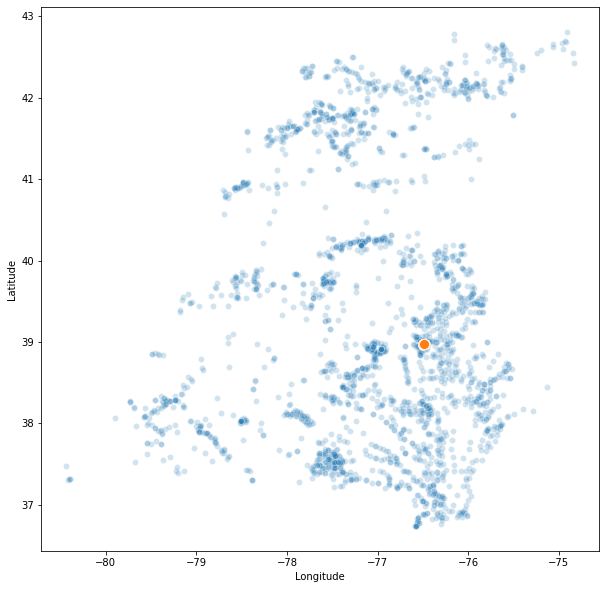

In [13]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]!="CO.2"].groupby("Station").first(), alpha=.2)
sns.scatterplot(x="Longitude", y="Latitude", data=df[df["Parameter"]=="CO.2"].groupby("Station").first(), **{"s":100})


The tiny point on the map(after scaling for visibility) indicates that these samples are in very close proximity to each other, compared to the rest of the data. Further investigation revealed the closest points having much different values, but they weren't that close comparatively. It may be worth revisiting to improve the model later.

In [15]:
df[df["Parameter"]=="CO.2"]["MeasureValue"] *= 1000

/opt/conda/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
def unnest_cmc_cbp_dataframe(data):

    df = data.copy()
    # Prior unit conversion
    np.where(df['Parameter'] == "CO.2", df["MeasureValue"] * 1000, df["MeasureValue"])

    # Creating new columns to break out the nested measurements
    for new_col in df["ParameterName_CBP"].unique():
        df[new_col] = np.where(df['ParameterName_CBP'] == new_col, df["MeasureValue"], np.nan)

    # Removing the original columns.
    df.drop(columns = ["Parameter", "ParameterName_CMC", "ParameterName_CBP", 'MeasureValue', 'Unit'], inplace=True)

    # Using these three values in a groupby, the dataframe will be tightened a bit without loss.
    groups = ["Date", "Station", "SampleDepth"]

    # Prevents Missing Sample Depth From Being dropped.
    df["SampleDepth"] = df["SampleDepth"].fillna(-999)

    # Flattens overlapping data removing nans
    df = df.groupby(groups).first().reset_index()

    #Returns sample depth back to original nans.
    df["SampleDepth"] = np.where(df["SampleDepth"]==-999, np.nan, df["SampleDepth"])
    
    return df

df = unnest_cmc_cbp_dataframe(df)

Upon examining the data for water temperature, the histogram indicates a major outlier.

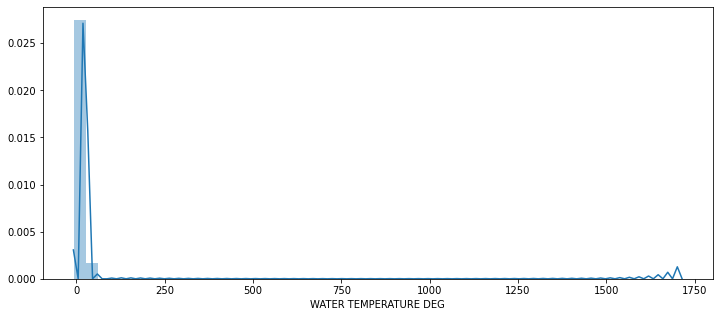

In [25]:
plt.figure(figsize=(12,5))
sns.distplot(df["WATER TEMPERATURE DEG"])

Further examination from anything that could be unusually high revealed what seems to be mistakes from wrong temperature units and missing decimals.

In [28]:
df[df["WATER TEMPERATURE DEG"]> 42][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
13678,CBP,F01,2005-10-24 12:05:00,0.5,XGG9992,55.8
16113,CBP,F01,2005-12-12 08:39:00,0.5,ET4.1,47.0
16114,CBP,F01,2005-12-12 08:39:00,1.0,ET4.1,48.0
16115,CBP,F01,2005-12-12 08:39:00,2.0,ET4.1,45.0
16116,CBP,F01,2005-12-12 08:39:00,3.0,ET4.1,45.0
16117,CBP,F01,2005-12-12 08:39:00,4.0,ET4.1,45.0
16118,CBP,F01,2005-12-12 08:39:00,4.9,ET4.1,47.0
16119,CBP,F01,2005-12-12 08:39:00,5.0,ET4.1,47.0
57356,CMC,NaN,2007-05-08 12:00:00,0.3,LCCD.MILL2,68.0
65203,CMC,NaN,2007-07-09 12:00:00,0.3,LCCD.MILL2,77.0


Examining the adjacent temperature readings of the biggest outlier confirms the missing decimal point.

In [29]:
mbj004 = df[df["Station"]=="MJB004.30"].set_index("Date").reset_index()
mbj004[mbj004["Date"]=="2010-04-13 09:18:00"][["Database", "Method", "Date", "SampleDepth", "Station", "WATER TEMPERATURE DEG"]]

,Database,Method,Date,SampleDepth,Station,WATER TEMPERATURE DEG
6,CBP,F01,2010-04-13 09:18:00,1.0,MJB004.30,17.13
7,CBP,F01,2010-04-13 09:18:00,2.0,MJB004.30,17.12
8,CBP,F01,2010-04-13 09:18:00,3.0,MJB004.30,1712.00
9,CBP,F01,2010-04-13 09:18:00,4.0,MJB004.30,16.96
10,CBP,F01,2010-04-13 09:18:00,5.0,MJB004.30,16.82
11,CBP,F01,2010-04-13 09:18:00,6.0,MJB004.30,16.83


The monthly averages converted to Fahrenheit are a strong match for the readings above 40C.

In [47]:
month_avg = df.copy()
month_avg["WATER TEMPERATURE DEG"] = np.where(month_avg["WATER TEMPERATURE DEG"] == 1712.00, 17.12, month_avg["WATER TEMPERATURE DEG"])
month_avg["Month"] = pd.DatetimeIndex(month_avg["Date"]).month
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].mean()*9/5+32

Month
1     40.817384
2     40.291811
3     45.361458
4     55.393987
5     64.672885
6     74.211934
7     79.632951
8     79.898076
9     74.754081
10    65.209118
11    53.648898
12    45.563896
Name: WATER TEMPERATURE DEG, dtype: float64

In [58]:
month_avg.groupby("Month")["WATER TEMPERATURE DEG"].describe()[["25%", "75%"]]

,25%,75%
Month,,
1,2.80,6.700
2,2.70,6.170
3,5.34,9.320
4,10.60,15.300
5,16.10,20.100
6,21.80,25.500
7,25.36,28.200
8,25.61,28.100
9,22.70,25.500


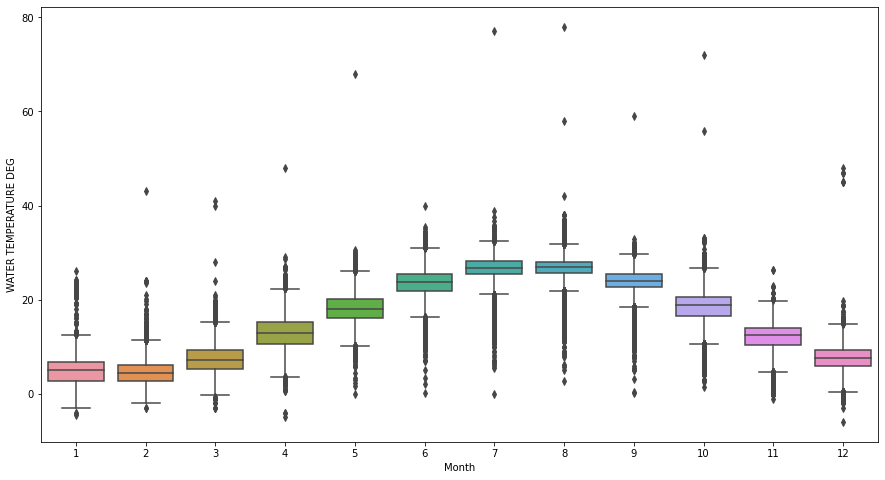

In [53]:
plt.figure(figsize = (15,8))
sns.boxplot(x="Month", y="WATER TEMPERATURE DEG", orient="v", data=month_avg)
    
plt.show()

In [359]:
def create_month_quartile_table(data, column):
    # Creates the quartiles for Celcius values
    prefix = ["Q1", "Q3"]
    suffix = ["_C", "_F"]
    df = data.groupby("Month")[column].describe()[["25%", "75%"]].copy()
    df.columns = [prefix[0], prefix[1]]
    df = pd.concat([df.add_suffix(suffix[0]), (df*9/5+ 32).add_suffix(suffix[1])], axis=1)
    return df


def fix_wrong_temperature_units_values(df, column, table, coef1, coef2):
    """In order for a unit swap to be detected the value must be both outside of range for values within
    assumed unit, but inside of range of alternate unit. Two coeficients that get applied to the IQR
    of each range control the threshold. As units converge, detection automatically becomes more difficult."""
    
    for month in np.arange(1,13):
        q1c, q3c, q1f, q3f = table.loc[month]
        deltac, deltaf = coef1 * (q3c - q1c), coef2 * (q3f-q1f)
        lowc, highc = q1c - deltac, q3c + deltac
        lowf, highf = q1f - deltaf, q3f + deltaf
        conversion = lambda x: (x-32) * 5/9
        df[column] = np.where((df["Month"]==month) & ((df[column]<=lowc) | (df[column]>=highc)) &
                              (df[column]>=lowf) & (df[column]<=highf), conversion(df[column]), df[column])
    return df


def fix_wrong_temperature_units(data, column, coef1, coef2):
    df = data.copy()
    df["Month"] = pd.DatetimeIndex(df["Date"]).month
    stats = create_month_quartile_table(df, column)
    df = fix_wrong_temperature_units_values(df, column, stats, coef1, coef2)
    df.drop(columns=["Month"], inplace=True)
    return df

In [369]:
def clean_cmc_cbp_dataframe(data):
    df = data.copy()
    df["WATER TEMPERATURE DEG"] = np.where(df["WATER TEMPERATURE DEG"] == 1712.00, 17.12, df["WATER TEMPERATURE DEG"])
    df = fix_wrong_temperature_units(df, "WATER TEMPERATURE DEG", 4, 1.5)
    df = fix_wrong_temperature_units(df, "AIR TEMPERATURE DEG", 4, 1.5)
    
    # Aggregating the sample depth data since units have been resolved.
    groups = ["Date", "Station"]
    cols = df.columns.difference(groups, sort=False)
    
    #Takes the mean of samples if the datatype is a float (All measured values were). Otherwise takes the first item.
    functions = ["mean" if df[col].dtype=="float" else "first" for col in cols]
    agg_list = dict(zip(cols,functions))
    df = df.groupby(groups).agg(agg_list).reset_index()
    
    #Removing addtional columns
    df.drop(columns = ['SampleDepth', 'SampleId', 'SampleReplicateType', 'SampleType'], inplace=True)
    return df

In [370]:
df2 = clean_cmc_cbp_dataframe(df)

In [371]:
df2

,Date,Station,Agency,BiasPC,CloudCover,Cruise,Database,FieldActivityEventType,FlowStage,GaugeHeight,...,Weather Conditions Yesterday,WindDirection,WindSpeed,Point,HUC12_,HUCNAME_,FIPS_,WATER TEMPERATURE DEG,SPECIFIC CONDUCTIVITY,AIR TEMPERATURE DEG
0,1992-11-01 12:00:00,LRA.LT1,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.18536999999998 40.17663),20503050404,Letort Spring Run,42041,10.00,NaN,NaN
1,1992-11-01 12:00:00,LRA.LT10,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.14193 40.23487),20503050404,Letort Spring Run,42041,7.75,NaN,NaN
2,1992-11-01 12:00:00,LRA.LT2,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.18507 40.17667),20503050404,Letort Spring Run,42041,8.75,NaN,NaN
3,1992-11-01 12:00:00,LRA.LT3,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.18692 40.17999),20503050404,Letort Spring Run,42041,9.50,NaN,NaN
4,1992-11-01 12:00:00,LRA.LT4,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.18606 40.18844),20503050404,Letort Spring Run,42041,8.50,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122633,2020-07-08 10:40:00,ARK.PR.2,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.1031 38.9187),20700100103,Pimmit Run-Potomac River,11001,28.00,NaN,27.0
122634,2020-07-08 10:48:00,PRK.PR-13,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.07417199999998 38.712452),20700100307,Little Hunting Creek-Potomac River,51059,26.50,NaN,24.5
122635,2020-07-08 10:54:00,ARK.AR.5,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.00060000000001 38.87278),20700100204,Lower Anacostia River,11001,29.00,NaN,29.0
122636,2020-07-08 11:18:00,ARK.AR.6,NaN,NaN,NaN,NaN,CMC,NaN,NaN,NaN,...,NaN,NaN,NaN,POINT (-77.0102 38.86535),20700100204,Lower Anacostia River,11001,28.00,NaN,29.0


In [312]:
# Using these three values in a groupby, the dataframe will be tightened a bit without loss.
groups = ["Date", "Station"]
df3 = df2.groupby(groups).first().reset_index()

In [16]:
full_value_counts(df, "Sea State")

There are 8 unique values with 2703287 nan values making up 99.8%
1906-<1 foot --0.07%
1529-Calm --0.06%
1183-<1 Foot --0.04%
469-<2 feet --0.02%
263-calm --0.01%
43-<2 Feet --0.00%
37-<3 feet --0.00%


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2708717 entries, 0 to 2708716
Data columns (total 71 columns):
 #   Column                                   Dtype         
---  ------                                   -----         
 0   Agency                                   object        
 1   BiasPC                                   object        
 2   CloudCover                               object        
 3   Comments                                 object        
 4   Cruise                                   object        
 5   Database                                 object        
 6   Date                                     datetime64[ns]
 7   FieldActivityEventType                   object        
 8   FieldActivityRemark                      float64       
 9   FlowStage                                object        
 10  GaugeHeight                              float64       
 11  GroupCode                                object        
 12  HUC12                       

In [53]:
df.columns

Index(['Agency', 'BiasPC', 'CloudCover', 'Comments', 'Cruise', 'Database',
       'Date', 'FieldActivityEventType', 'FlowStage', 'GaugeHeight',
       'GroupCode', 'HUC12', 'Lab', 'Latitude', 'Layer', 'Longitude',
       'LowerPycnocline', 'MeasureValue', 'Method', 'ModifiedDate',
       'Other Comments', 'Other Conditions', 'Parameter', 'ParameterName_CBP',
       'ParameterName_CMC', 'PrecipType', 'Pressure', 'Problem', 'Program',
       'Project', 'Qualifier', 'Rainfall', 'Rainfall Within 24 Hours',
       'Rainfall Within 48 Hours', 'SampleDepth', 'SampleId',
       'SampleReplicateType', 'SampleType', 'Sea State', 'Source', 'Station',
       'StationCode', 'StationName', 'Stream Flow', 'Tidal Stage', 'TideStage',
       'TierLevel', 'Time', 'TotalDepth', 'Unit', 'UpperPycnocline',
       'Water Color', 'Water Color Description', 'Water Odor',
       'Water Odor Description', 'Water Surfaces', 'WaveHeight',
       'Weather Conditions Day Before Yesterday', 'Weather Conditions Today

In [40]:
df.sort_values("Date")

,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,FlowStage,GaugeHeight,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
61127,NaN,NaN,NaN,NaN,NaN,CMC,1992-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,PA,POINT (-77.18104 40.20792),20503050404,Letort Spring Run,42041,Cumberland County,PA
211099,NaN,NaN,NaN,NaN,NaN,CMC,1992-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,PA,POINT (-77.18423 40.19528),20503050404,Letort Spring Run,42041,Cumberland County,PA
211100,NaN,NaN,NaN,NaN,NaN,CMC,1992-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,PA,POINT (-77.18104 40.20792),20503050404,Letort Spring Run,42041,Cumberland County,PA
211101,NaN,NaN,NaN,NaN,NaN,CMC,1992-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,PA,POINT (-77.16883 40.21418),20503050404,Letort Spring Run,42041,Cumberland County,PA
211102,NaN,NaN,NaN,NaN,NaN,CMC,1992-11-01,NaN,NaN,NaN,...,NaN,NaN,NaN,PA,POINT (-77.16003000000001 40.21847),20503050404,Letort Spring Run,42041,Cumberland County,PA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22151,NaN,NaN,NaN,NaN,NaN,CMC,2020-07-08,NaN,NaN,NaN,...,NaN,NaN,NaN,MD,POINT (-77.263728 38.4691169),20700110106,Tank Creek-Potomac River,24017,Charles County,MD
22152,NaN,NaN,NaN,NaN,NaN,CMC,2020-07-08,NaN,NaN,NaN,...,NaN,NaN,NaN,MD,POINT (-77.2694645 38.459693),20700110106,Tank Creek-Potomac River,24017,Charles County,MD
22153,NaN,NaN,NaN,NaN,NaN,CMC,2020-07-08,NaN,NaN,NaN,...,NaN,NaN,NaN,MD,POINT (-77.018505 38.784099),20700100307,Little Hunting Creek-Potomac River,24033,Prince George's County,MD
66594,NaN,NaN,NaN,NaN,NaN,CMC,2020-07-08,NaN,NaN,NaN,...,NaN,NaN,NaN,MD,POINT (-77.018505 38.784099),20700100307,Little Hunting Creek-Potomac River,24033,Prince George's County,MD


In [58]:
df[df["Parameter"] == "DO"]["MeasureValue"].mean()

7.895909943695156

In [66]:
df[df["Parameter"] == "DO.8"]["MeasureValue"].mean()

8.214134271784452

In [67]:
df

,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,FlowStage,GaugeHeight,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,NaN,NaN,NaN,NaN,NaN,CMC,2018-04-28,NaN,NaN,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.93002800000002 39.480194),20600020206,Bohemia River,24015,Cecil County,MD
1,NaN,NaN,NaN,NaN,NaN,CMC,2018-04-28,NaN,NaN,NaN,...,NaN,W,1-10 knots,MD,POINT (-75.902528 39.480444),20600020206,Bohemia River,24015,Cecil County,MD
2,NaN,NaN,NaN,NaN,NaN,CMC,2018-04-28,NaN,NaN,NaN,...,NaN,S,1-10 knots,MD,POINT (-75.873639 39.466889),20600020206,Bohemia River,24015,Cecil County,MD
3,NaN,NaN,NaN,NaN,NaN,CMC,2018-04-28,NaN,NaN,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.854444 39.454),20600020206,Bohemia River,24015,Cecil County,MD
4,NaN,NaN,NaN,NaN,NaN,CMC,2018-04-28,NaN,NaN,NaN,...,NaN,SW,1-10 knots,MD,POINT (-75.84352800000001 39.463667),20600020206,Bohemia River,24015,Cecil County,MD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708712,VADEQ,NaN,NaN,NaN,BAY684,CBP,2016-11-08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-76.33835999999999 36.90456),20802080304,Hampton Roads,51710,Norfolk city,VA
2708713,VADEQ,NaN,NaN,NaN,BAY684,CBP,2016-11-08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-76.33835999999999 36.90456),20802080304,Hampton Roads,51710,Norfolk city,VA
2708714,VADEQ,NaN,NaN,NaN,BAY684,CBP,2016-11-08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-76.33835999999999 36.90456),20802080304,Hampton Roads,51710,Norfolk city,VA
2708715,VADEQ,NaN,NaN,NaN,BAY684,CBP,2016-11-08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-76.33835999999999 36.90456),20802080304,Hampton Roads,51710,Norfolk city,VA


In [47]:
un1 = df[df["Database"]=="CBP"]["Station"].unique()

In [42]:
un2 = df[df["Database"]=="CMC"]["StationCode"].unique()

In [45]:
un1.size + un2.size

2581

In [53]:
df['Station'] = np.where(df['Station'].isnull(), df['StationCode'], df['Station'])

In [ ]:
test = "outgoing (ebb)"
re.match()

In [34]:
x = df.copy()


In [49]:
full_value_counts(df[df["Database"]=="CMC"], "Weather Conditions Today")

There are 23 unique values with 148540 nan values making up 56.2%
55586-Sunny --21.03%
25844-Overcast --9.78%
13028-Partly Cloudy --4.93%
11742-Partly cloudy --4.44%
3468-Rain --1.31%
1169-sunny --0.44%
896-Drizzle --0.34%
764-intermittent Rain --0.29%
576-partly cloudy --0.22%
555-SUNNY --0.21%
508-Intermittent Rain --0.19%
499-Intermittent rain --0.19%
451-overcast --0.17%
174-Fog/haze --0.07%
157-Snow --0.06%
136-Fog/Haze --0.05%
76-drizzle --0.03%
42-Overcast  --0.02%
22-SUNNY  --0.01%
13-rain --0.00%
8-Sunny  --0.00%
7-partly Cloudy --0.00%


In [64]:
full_value_counts(df[df["Database"]=="CMC"], "WindSpeed")

There are 7 unique values with 229469 nan values making up 86.8%
16722-Calm --6.33%
16368-1-10 knots --6.19%
1534-10-20 knots --0.58%
133-1-10 Knots --0.05%
29-10-20 Knots --0.01%
6-20-30 knots --0.00%


In [12]:
df.iloc[0:25,0:12]

,Agency,BiasPC,CloudCover,Cruise,Database,Date,FieldActivityEventType,FlowStage,GaugeHeight,GroupCode,HUC12,Lab
0,NaN,NaN,NaN,NaN,CMC,2018-04-28 12:05:00,NaN,NaN,NaN,FB,NaN,NaN
1,NaN,NaN,NaN,NaN,CMC,2018-04-28 12:40:00,NaN,NaN,NaN,FB,NaN,NaN
2,NaN,NaN,NaN,NaN,CMC,2018-04-28 13:13:00,NaN,NaN,NaN,FB,NaN,NaN
3,NaN,NaN,NaN,NaN,CMC,2018-04-28 13:53:00,NaN,NaN,NaN,FB,NaN,NaN
4,NaN,NaN,NaN,NaN,CMC,2018-04-28 14:24:00,NaN,NaN,NaN,FB,NaN,NaN
5,NaN,NaN,NaN,NaN,CMC,2018-04-28 14:53:00,NaN,NaN,NaN,FB,NaN,NaN
6,NaN,NaN,NaN,NaN,CMC,2018-05-08 10:43:00,NaN,NaN,NaN,FB,NaN,NaN
7,NaN,NaN,NaN,NaN,CMC,2018-05-08 11:16:00,NaN,NaN,NaN,FB,NaN,NaN
8,NaN,NaN,NaN,NaN,CMC,2018-05-08 11:42:00,NaN,NaN,NaN,FB,NaN,NaN
9,NaN,NaN,NaN,NaN,CMC,2018-05-08 12:22:00,NaN,NaN,NaN,FB,NaN,NaN
